# Pensacola Bay FL - Detailed step-by-step

## Standardize, clean and wrangle Water Quality Portal data in Pensacola and Perdido Bays into more analytic-ready formats using the harmonize_wq package


US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:

- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Pensacola and Perdido Bays

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
#!python -m pip install harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


#### Download location data using dataretrieval

<Axes: >

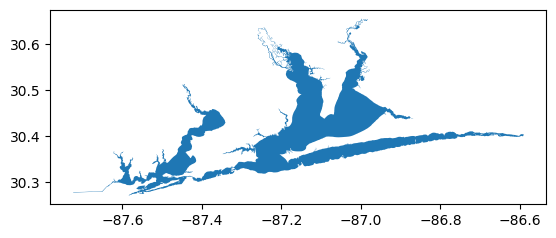

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://raw.githubusercontent.com/USEPA/harmonize-wq/main/harmonize_wq/tests/data/PPBays_NCCA.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)  # already standard 4326
aoi_gdf.plot()

In [4]:
# Note there are actually two polygons (one for each Bay)
aoi_gdf
# Spatial query parameters can be updated to run just one
bBox = wrangle.get_bounding_box(aoi_gdf)
# For only one bay, e.g., first is Pensacola Bay:
#bBox = wrangle.get_bounding_box(aoi_gdf, 0)

In [5]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [6]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [7]:
# Rows and columns for results
stations.shape

(2867, 37)

In [8]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-AL,USGS Alabama Water Science Center,USGS-02376115,"ELEVENMILE CREEK NR WEST PENSACOLA, FL",Stream,NaN,3140107.0,27.8,sq mi,27.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-AL,USGS Alabama Water Science Center,USGS-02377570,"STYX RIVER NEAR ELSANOR, AL.",Stream,NaN,3140106.0,192.0,sq mi,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-AL,USGS Alabama Water Science Center,USGS-02377920,"BLACKWATER RIVER AT US HWY 90 NR ROBERTSDALE, AL.",Stream,NaN,3140106.0,23.1,sq mi,23.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-AL,USGS Alabama Water Science Center,USGS-02377960,"BLACKWATER RIVER AT CO RD 87 NEAR ELSANOR, AL.",Stream,NaN,3140106.0,56.6,sq mi,56.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-AL,USGS Alabama Water Science Center,USGS-02377975,BLACKWATER RIVER ABOVE SEMINOLE AL,Stream,NaN,3140106.0,40.2,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [9]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 30.498252
LongitudeMeasure                               -87.335809
Name: 0, dtype: object

In [10]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, out_EPSG=4326, intermediate_columns=True)

In [11]:
location.harmonize_locations?

In [12]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(2867, 42)

In [13]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-87.3358086, 30.49825159)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-87.3358086 30.49825159)
geometry     POINT (-87.3358086 30.49825159)
Name: 0, dtype: object

In [14]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [15]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'}

<Axes: >

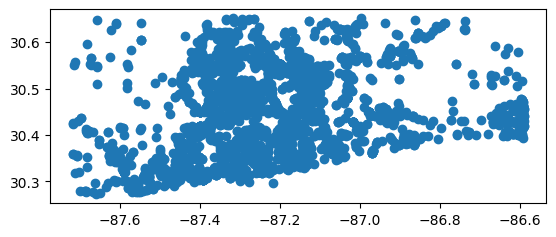

In [16]:
# Map it
stations_gdf.plot()

In [17]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

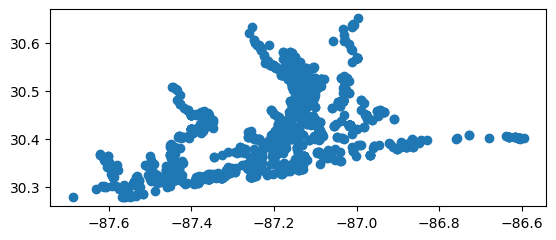

In [18]:
# Map it
stations_clipped.plot()

In [19]:
# How many stations now?
len(stations_clipped)

1422

In [20]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'PPBEP_stations.shp'))

#### Retrieve Characteristic Data

In [21]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/dataretrieval/wqp.py:83: DtypeWarning: Columns (10,13,15,17,19,20,21,22,23,28,31,33,34,36,58,60,61,64,65,69,70,71,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [22]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-027950424132,2013-04-24,09:01:00,EST,21FLSEAS_WQX-02SEAS795,STORET-310551339,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-027400613134,2013-06-13,10:01:00,EST,21FLSEAS_WQX-02SEAS740,STORET-310489836,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1536988F1,2013-09-17,11:01:00,EST,21FLPNS_WQX-33030019,STORET-308146602,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520810L,2013-07-23,10:01:00,EST,21FLPNS_WQX-33020146,STORET-308157908,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,2013-09-23,17:15:00,CST,21FLCBA_WQX-BAS02,STORET-760593202,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431295,USGS-AL,USGS Alabama Water Science Center,nwisal.01.99900500,1999-03-02,14:20:00,CST,USGS-02376115,NWIS-104002666,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
431296,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00201479,2001-11-28,12:05:00,CST,USGS-02377570,NWIS-53918846,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
431297,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00202076,2001-10-03,16:40:00,CDT,USGS-02376115,NWIS-104000948,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
431298,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00202072,2001-11-28,13:45:00,CST,USGS-02376115,NWIS-104000936,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

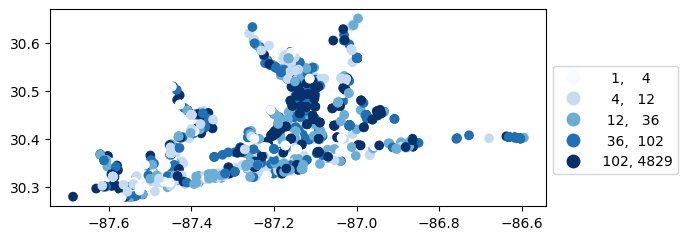

In [23]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [24]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

-Usable results-
count    15773.000000
mean         1.172124
std          2.229478
min          0.000000
25%          0.600000
50%          1.000000
75%          1.423333
max        260.000000
dtype: float64
Unusable results: 79
Usable results with inferred units: 0
Results outside threshold (0.0 to 14.548994279536801): 1


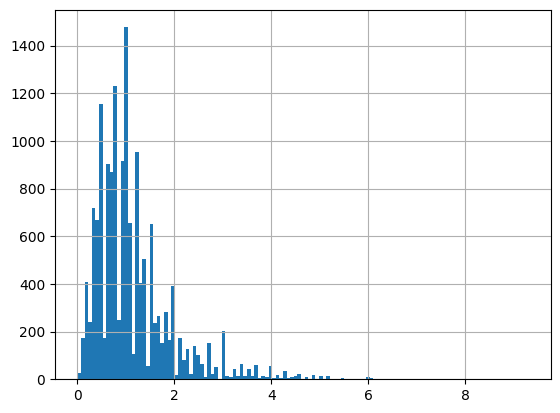

In [25]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [26]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
84,21AWIC-7290,.94,m,NaN,m,0.94 meter
96,21FLPNS_WQX-33020JF1,0.60,m,NaN,m,0.6 meter
113,21FLGW_WQX-3565,.3,m,NaN,m,0.3 meter
124,21FLBFA_WQX-33010016,1.5,m,NaN,m,1.5 meter
127,21FLBFA_WQX-33010030,1.25,m,NaN,m,1.25 meter
...,...,...,...,...,...,...
429445,21AWIC-1122,1.65,m,NaN,m,1.65 meter
429453,21AWIC-7290,.9,m,NaN,m,0.9 meter
429454,21AWIC-1208,1,m,NaN,m,1.0 meter
429458,21AWIC-1207,.79,m,NaN,m,0.79 meter


In [27]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
127393,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
127407,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
127736,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
127935,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
129011,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
255714,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
255793,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
257387,21FLKWAT_WQX-SAN-SKI WATCH-5,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
258091,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [28]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [29]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
127393,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
127407,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
127736,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
127935,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
129011,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
255714,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
255793,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
257387,21FLKWAT_WQX-SAN-SKI WATCH-5,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
258091,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [30]:
# Aggregate Secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_CMP_PKT01,12,2.333333
1,11NPSWRD_WQX-GUIS_CMP_PKT02,17,2.411765
2,11NPSWRD_WQX-GUIS_CMP_PKT03,3,2.333333
3,21AWIC-1063,124,0.775726
4,21AWIC-1122,64,2.981156
...,...,...,...
1080,NARS_WQX-NCCA10-1432,1,1.075000
1081,NARS_WQX-NCCA10-1433,1,1.423333
1082,NARS_WQX-NCCA10-1434,1,2.400000
1083,NARS_WQX-NCCA10-1488,1,0.736667


<Axes: >

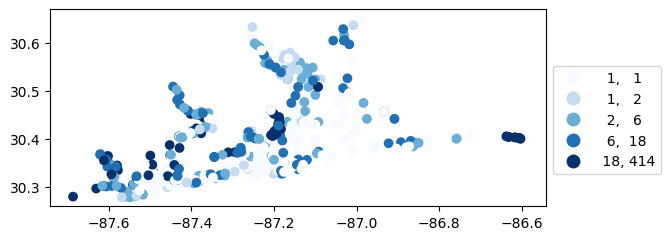

In [31]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

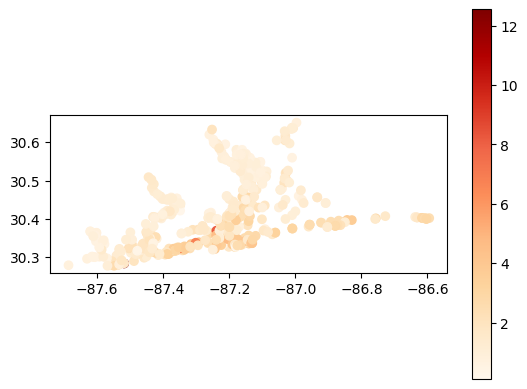

In [32]:
# Map average secchi depth results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

-Usable results-
count    86520.000000
mean        22.004521
std         10.159882
min        -12.944444
25%         17.055556
50%         22.230000
75%         27.200000
max       1876.000000
dtype: float64
Unusable results: 2
Usable results with inferred units: 10
Results outside threshold (0.0 to 82.96381273909573): 7


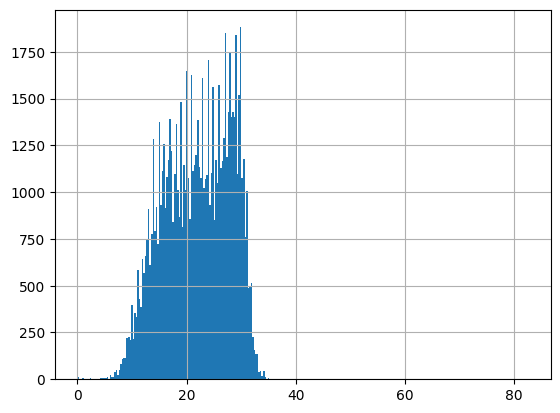

In [33]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [34]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
4,21FLCBA_WQX-BAS02,78.9,deg F,NaN,26.0555555555556 degree_Celsius,degF
6,21FLPNS_WQX-33020J10,12.35,deg C,NaN,12.35 degree_Celsius,degC
21,21FLSEAS_WQX-02SEAS810,23,deg C,NaN,23.0 degree_Celsius,degC
22,21FLPNS_WQX-33010G10,11.23,deg C,NaN,11.23 degree_Celsius,degC
37,AWW_WQX-aww_2174,27,deg C,NaN,27.0 degree_Celsius,degC
...,...,...,...,...,...,...
431295,USGS-02376115,23.0,deg C,NaN,23.0 degree_Celsius,degC
431296,USGS-02377570,20.0,deg C,NaN,20.0 degree_Celsius,degC
431297,USGS-02376115,25.0,deg C,NaN,25.0 degree_Celsius,degC
431298,USGS-02376115,24.0,deg C,NaN,24.0 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
169965,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
233830,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
233835,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
234417,21FLCBA-FWB02,82.1,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.1 degree_Celsius,degC
234418,21FLCBA-FWB02,82.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.6 degree_Celsius,degC
234419,21FLCBA-FWB02,71.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.8 degree_Celsius,degC
234420,21FLCBA-FWB02,79.4,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.4 degree_Celsius,degC
236018,21FLCBA-FWB01,83.3,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",83.3 degree_Celsius,degC
236843,21FLCBA-FWB05,79.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.8 degree_Celsius,degC
237942,21FLCBA-FWB01,71.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.2 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
52841,11NPSWRD_WQX-GUIS_NALO,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
169965,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,24.986667
1,11NPSWRD_WQX-GUIS_BCCA,1,36.800000
2,11NPSWRD_WQX-GUIS_BISA,32,22.696250
3,11NPSWRD_WQX-GUIS_BOPI,1,32.000000
4,11NPSWRD_WQX-GUIS_CMP_PKT01,20,25.125000
...,...,...,...
2473,UWFCEDB_WQX-SRC-AI31-22,15,22.126667
2474,UWFCEDB_WQX-SRC-AI36-22,18,22.133333
2475,UWFCEDB_WQX-SRC-AI42-22,16,22.362500
2476,UWFCEDB_WQX-SRC-AI44-22,18,21.972222


<Axes: >

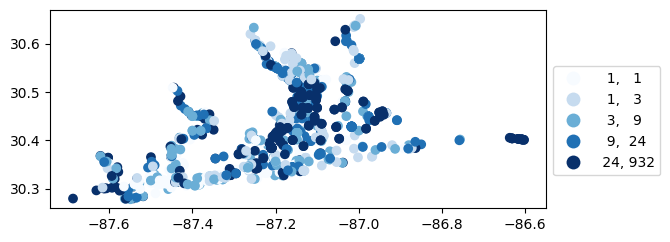

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

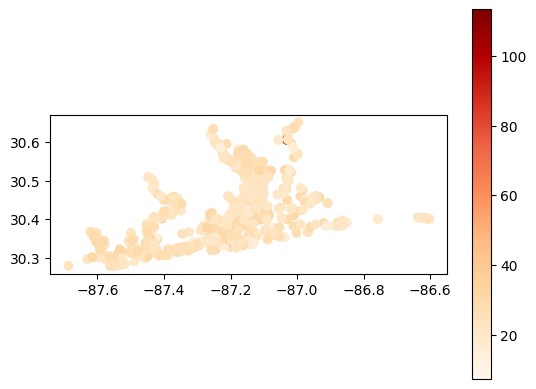

In [40]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
1,21FLSEAS_WQX-02SEAS740,6.3,mg/L,NaN,6.3 milligram / liter
5,21FLCMP_WQX-3201BM21,4.5,mg/L,NaN,4.5 milligram / liter
12,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
16,21FLBFA_WQX-33020057,1.17,mg/L,NaN,1.17 milligram / liter
25,21FLNUTT_WQX-PB02,8.11,mg/L,NaN,8.11 milligram / liter
...,...,...,...,...,...
431162,21AWIC-1152,8.6,mg/L,NaN,8.6 milligram / liter
431164,21AWIC-1152,7.8,mg/L,NaN,7.8 milligram / liter
431168,21AWIC-1152,8.6,mg/L,NaN,8.6 milligram / liter
431186,21AWIC-1152,7.8,mg/L,NaN,7.8 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
1,21FLSEAS_WQX-02SEAS740,6.3,mg/L,NaN,6.3 milligram / liter
5,21FLCMP_WQX-3201BM21,4.5,mg/L,NaN,4.5 milligram / liter
12,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
16,21FLBFA_WQX-33020057,1.17,mg/L,NaN,1.17 milligram / liter
25,21FLNUTT_WQX-PB02,8.11,mg/L,NaN,8.11 milligram / liter
...,...,...,...,...,...
431162,21AWIC-1152,8.6,mg/L,NaN,8.6 milligram / liter
431164,21AWIC-1152,7.8,mg/L,NaN,7.8 milligram / liter
431168,21AWIC-1152,8.6,mg/L,NaN,8.6 milligram / liter
431186,21AWIC-1152,7.8,mg/L,NaN,7.8 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate DO data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,6.698000
1,11NPSWRD_WQX-GUIS_BCCA,1,0.270000
2,11NPSWRD_WQX-GUIS_BISA,32,7.194375
3,11NPSWRD_WQX-GUIS_BOPI,1,7.540000
4,11NPSWRD_WQX-GUIS_FPPO,1,9.950000
...,...,...,...
2050,UWFCEDB_WQX-SRC-AI31-22,30,3.711982
2051,UWFCEDB_WQX-SRC-AI36-22,36,3.470604
2052,UWFCEDB_WQX-SRC-AI42-22,32,3.706811
2053,UWFCEDB_WQX-SRC-AI44-22,36,3.702338


<Axes: >

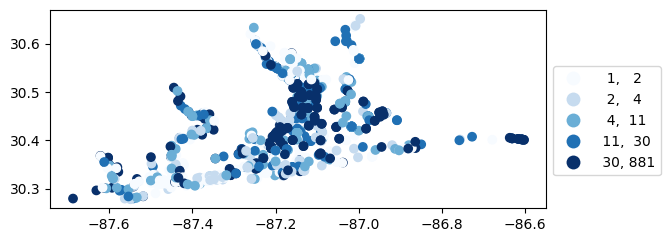

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

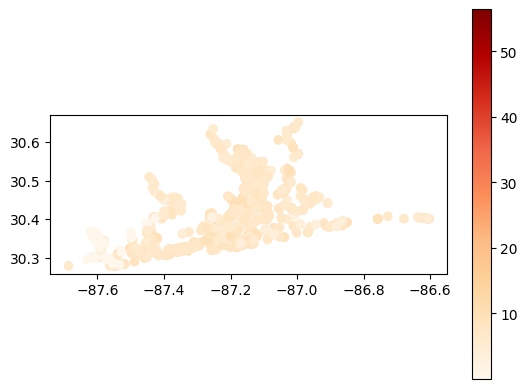

In [46]:
# Map Averages at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

###### pH

-Usable results-
count    58044.000000
mean         7.343410
std          0.901763
min          0.500000
25%          6.870000
50%          7.680000
75%          8.000000
max         16.200000
dtype: float64
Unusable results: 51
Usable results with inferred units: 36
Results outside threshold (0.0 to 12.753988274241003): 1


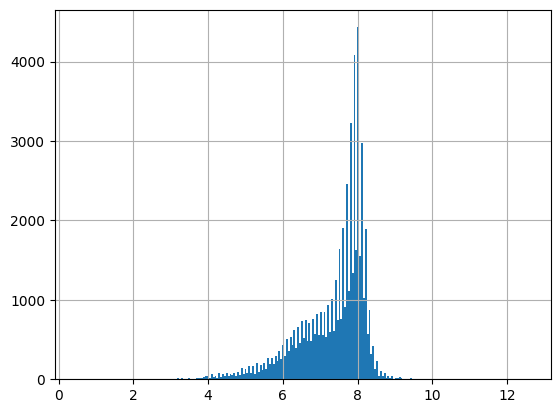

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
2,7.29,None,NaN,7.29 dimensionless
19,8.09,None,NaN,8.09 dimensionless
24,7.45,None,NaN,7.45 dimensionless
27,6.57,None,NaN,6.57 dimensionless
29,6.57,None,NaN,6.57 dimensionless
...,...,...,...,...
431264,7.25,None,NaN,7.25 dimensionless
431268,7,None,NaN,7.0 dimensionless
431270,8.27,None,NaN,8.27 dimensionless
431271,8.47,None,NaN,8.47 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

-Usable results-
count    73929.000000
mean        15.966853
std        150.247107
min          0.000000
25%          6.000000
50%         16.200000
75%         23.320000
max      37782.000000
dtype: float64
Unusable results: 417
Usable results with inferred units: 10
Results outside threshold (0.0 to 917.4494966818058): 4


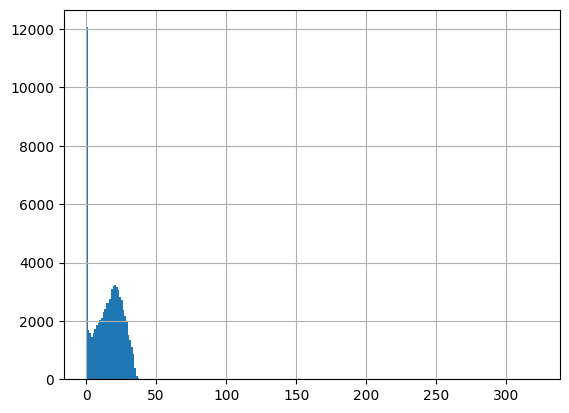

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True)

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
9,18.9,ppth,NaN,18.9 Practical_Salinity_Units
11,11.82,ppth,NaN,11.82 Practical_Salinity_Units
17,.03,ppt,NaN,0.03 Practical_Salinity_Units
23,33.27,ppth,NaN,33.27 Practical_Salinity_Units
28,25.16,ppth,NaN,25.16 Practical_Salinity_Units
...,...,...,...,...
431263,2.16,ppth,NaN,2.16 Practical_Salinity_Units
431265,2.07,ppth,NaN,2.07 Practical_Salinity_Units
431266,2.11,ppth,NaN,2.11 Practical_Salinity_Units
431269,1.89,ppth,NaN,1.89 Practical_Salinity_Units


###### Nitrogen

/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)


-Usable results-
count     109.000000
mean       26.920174
std       160.257726
min         0.000700
25%         0.410000
50%         0.629000
75%         1.120000
max      1630.000000
dtype: float64
Unusable results: 4
Usable results with inferred units: 0
Results outside threshold (0.0 to 988.4665321860789): 1


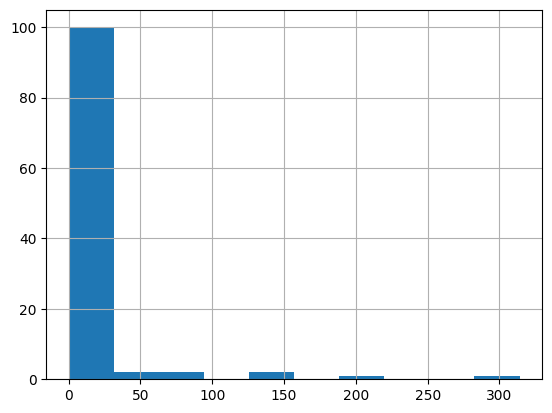

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
51238,0.3,mg/L,NaN,0.3 milligram / liter
51494,0.36,mg/L,NaN,0.36 milligram / liter
51588,0.33875,mg/L,NaN,0.33875 milligram / liter
51678,0.53125,mg/L,NaN,0.53125 milligram / liter
52259,135,mg/kg,NaN,135.00000000000003 milligram / liter
...,...,...,...,...
430726,18.69,mg/l,NaN,18.69 milligram / liter
430733,16.18,mg/l,NaN,16.18 milligram / liter
430734,18.99,mg/l,NaN,18.99 milligram / liter
430737,18.72,mg/l,NaN,18.72 milligram / liter


###### Conductivity

-Usable results-
count     1818.000000
mean     17085.221414
std      16116.889030
min          0.040000
25%        130.000000
50%      16994.750000
75%      30306.650000
max      54886.200000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 113786.55559242623): 0


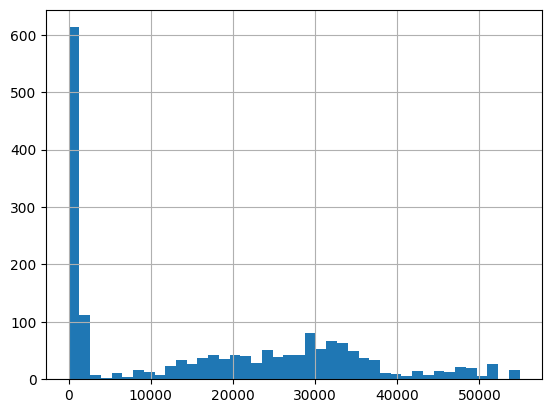

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
13,19204.2,umho/cm,NaN,19204.2 microsiemens / centimeter
93,222.3,umho/cm,NaN,222.3 microsiemens / centimeter
193,102.8,umho/cm,NaN,102.8 microsiemens / centimeter
385,11017.5,umho/cm,NaN,11017.5 microsiemens / centimeter
793,32,umho/cm,NaN,32.0 microsiemens / centimeter
...,...,...,...,...
431111,40000,umho/cm,NaN,40000.0 microsiemens / centimeter
431114,69,umho/cm,NaN,69.0 microsiemens / centimeter
431115,119,umho/cm,NaN,119.0 microsiemens / centimeter
431118,100,umho/cm,NaN,100.0 microsiemens / centimeter


###### Chlorophyll a

/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'None' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


-Usable results-
count    9408.000000
mean        1.152038
std         1.199480
min        -0.840000
25%         0.007699
50%         0.950000
75%         1.820000
max         9.990000
dtype: float64
Unusable results: 628
Usable results with inferred units: 0
Results outside threshold (0.0 to 8.348917067148339): 8


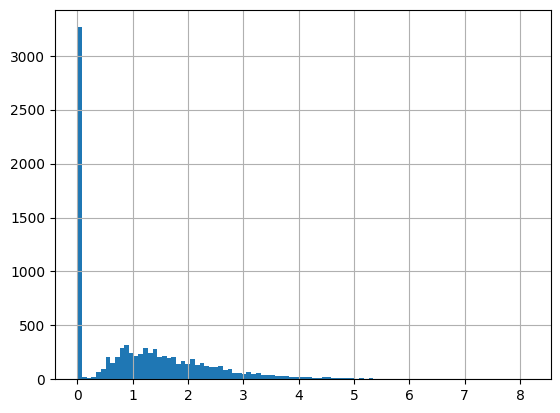

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
247,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
552,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
660,2.3,mg/m3,NaN,0.0023000000000000004 milligram / liter
1206,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
1351,2.9,mg/m3,NaN,0.0029000000000000007 milligram / liter
...,...,...,...,...
430932,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
430947,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
430957,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
431161,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


###### Organic Carbon

-Usable results-
count      4869.000000
mean       1128.337669
std       11539.141214
min           0.000000
25%           2.700000
50%           4.300000
75%           8.200000
max      410000.000000
dtype: float64
Unusable results: 165
Usable results with inferred units: 0
Results outside threshold (0.0 to 70363.18495043386): 22


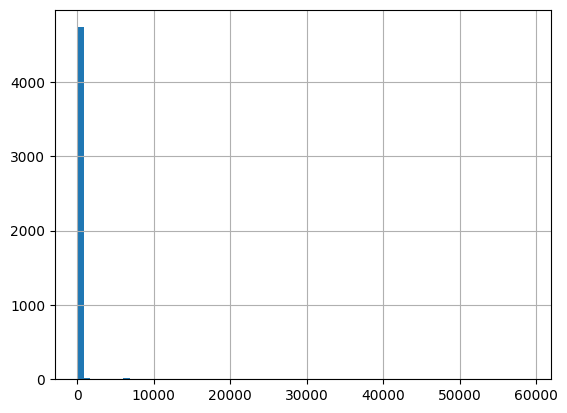

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
121,5.4,mg/L,NaN,5.4 milligram / liter
123,2.6,mg/L,NaN,2.6 milligram / liter
158,3.9,mg/L,NaN,3.9 milligram / liter
210,5.2,mg/L,NaN,5.2 milligram / liter
265,6.0,mg/L,NaN,6.0 milligram / liter
...,...,...,...,...
430931,3.393,mg/L,NaN,3.393 milligram / liter
430938,4.769,mg/L,NaN,4.769 milligram / liter
430974,3.264,mg/L,NaN,3.264 milligram / liter
431183,6.206,mg/L,NaN,6.206 milligram / liter


###### Turbidity

-Usable results-
count    42943.000000
mean        17.066404
std        204.703654
min         -0.840000
25%          1.500000
50%          2.700000
75%          5.500000
max      32342.452300
dtype: float64
Unusable results: 596
Usable results with inferred units: 10
Results outside threshold (0.0 to 1245.2883266264932): 48


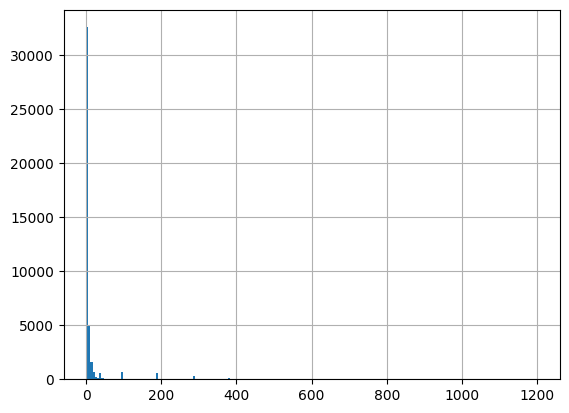

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True)

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
26,0,NTU,NaN,0.0 Nephelometric_Turbidity_Units
44,1.4,NTU,NaN,1.4 Nephelometric_Turbidity_Units
50,4.7,NTU,NaN,4.7 Nephelometric_Turbidity_Units
83,NaN,NTU,ResultMeasureValue: missing (NaN) result,NaN
102,5.6,NTU,NaN,5.6 Nephelometric_Turbidity_Units
...,...,...,...,...
431151,16,NTU,NaN,16.0 Nephelometric_Turbidity_Units
431157,18,NTU,NaN,18.0 Nephelometric_Turbidity_Units
431158,16,NTU,NaN,16.0 Nephelometric_Turbidity_Units
431178,11.7,NTU,NaN,11.7 Nephelometric_Turbidity_Units


###### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


###### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
35,.061,mg/L,NaN,NaN
66,0.03,mg/L,NaN,NaN
153,.13,mg/L,NaN,NaN
180,0.003,mg/L,NaN,NaN
319,0.002,mg/L,NaN,NaN
...,...,...,...,...
431102,.25,mg/L,NaN,NaN
431113,.23,mg/L,NaN,NaN
431117,.2,mg/L,NaN,NaN
431123,.19,mg/L,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
35,.061,mg/L,NaN,NaN
66,0.03,mg/L,NaN,NaN
153,.13,mg/L,NaN,NaN
180,0.003,mg/L,NaN,NaN
319,0.002,mg/L,NaN,NaN
...,...,...,...,...
430592,0.08,mg/l as P,NaN,NaN
430599,0.05,mg/l as P,NaN,NaN
430763,0.110,mg/l as P,NaN,NaN
430934,.053,mg/L,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3688,0.019,mg/L,NaN,0.019 milligram / liter
8183,0.002,mg/L,NaN,0.002 milligram / liter
14071,0.003,mg/L,NaN,0.003 milligram / liter
17165,0.019,mg/L,NaN,0.019 milligram / liter
45606,0.002,mg/L,NaN,0.002 milligram / liter
47533,0.017,mg/L,NaN,0.017 milligram / liter
60804,0.020,mg/L,NaN,0.02 milligram / liter
66754,0.002,mg/L,NaN,0.002 milligram / liter
71192,0.021,mg/L,NaN,0.021 milligram / liter
73996,0.003,mg/L,NaN,0.003 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
25216,.5,mg/L,NaN,NaN
25293,.036,mg/L,NaN,NaN
26623,.089,mg/L,NaN,NaN
27582,.017,mg/L,NaN,NaN
28687,.035,mg/L,NaN,NaN
...,...,...,...,...
431099,.144,mg/L,NaN,NaN
431102,.25,mg/L,NaN,NaN
431113,.23,mg/L,NaN,NaN
431117,.2,mg/L,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    10035.000000
mean        45.537618
std        448.839329
min          0.000000
25%          4.000000
50%          8.000000
75%         33.000000
max      33000.000000
dtype: float64
Unusable results: 40571
Usable results with inferred units: 0
Results outside threshold (0.0 to 2738.5735941387825): 6


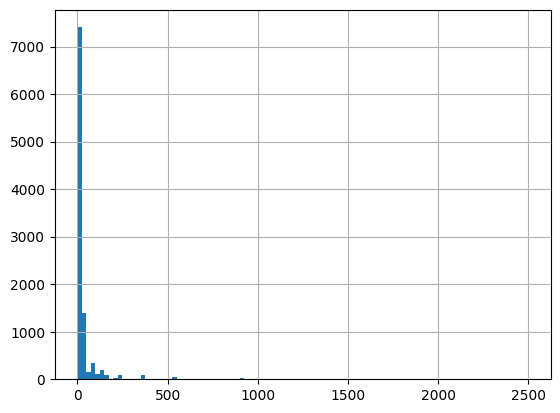

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
0,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
3,80,cfu/100mL,NaN,NaN
7,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
8,2,MPN/100mL,NaN,NaN
10,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
...,...,...,...,...
430631,145,cfu/100mL,NaN,NaN
430657,317,cfu/100mL,NaN,NaN
430679,60,cfu/100mL,NaN,NaN
431077,600,cfu/100mL,NaN,NaN


###### Escherichia coli

/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      22.000000
mean      501.863636
std       610.053260
min         4.000000
25%         9.500000
50%        77.500000
75%      1000.000000
max      1700.000000
dtype: float64
Unusable results: 8967
Usable results with inferred units: 0
Results outside threshold (0.0 to 4162.183198738116): 0


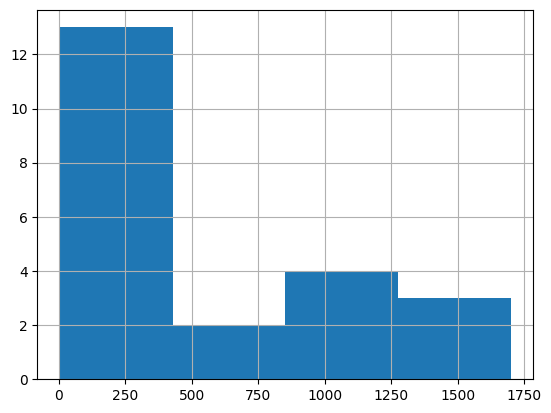

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
20,0,cfu/100mL,NaN,NaN
63,1000,cfu/100mL,NaN,NaN
69,33.3333333333333,cfu/100mL,NaN,NaN
82,0,cfu/100mL,NaN,NaN
138,0,cfu/100mL,NaN,NaN
...,...,...,...,...
430951,100,MPN/100mL,NaN,NaN
430954,580,MPN/100mL,NaN,NaN
430976,82,MPN/100mL,NaN,NaN
431166,15,MPN/100mL,NaN,NaN


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 37782.0
Results: 73929 
Mean: 15.966852842592548 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[15030.0, 37782.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
12630,15030,ppt,NaN,15030.0 Practical_Salinity_Units
22126,322,ppth,NaN,322.0 Practical_Salinity_Units
50765,2150,ppth,NaN,2150.0 Practical_Salinity_Units
107713,37782,ppth,NaN,37782.0 Practical_Salinity_Units
153075,2190,ppt,NaN,2190.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
from harmonize_wq import wrangle

In [78]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [79]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
2174,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
3812,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
9848,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
18173,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
32679,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
428400,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
428411,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
428549,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
428582,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [80]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

13        19204.2 microsiemens / centimeter
93          222.3 microsiemens / centimeter
193         102.8 microsiemens / centimeter
385       11017.5 microsiemens / centimeter
793          32.0 microsiemens / centimeter
                        ...                
431111    40000.0 microsiemens / centimeter
431114       69.0 microsiemens / centimeter
431115      119.0 microsiemens / centimeter
431118      100.0 microsiemens / centimeter
431124       85.0 microsiemens / centimeter
Name: Conductivity, Length: 1818, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [81]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
139702,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
142996,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
136310,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
141729,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
135678,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
84563,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
153194,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
59725,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
36856,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [82]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
139702,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
142996,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
136310,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
141729,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
135678,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
84563,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
153194,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
59725,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
36856,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [83]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

139702    36.356 dimensionless
142996    36.345 dimensionless
136310    36.338 dimensionless
141729    36.336 dimensionless
135678     36.33 dimensionless
                  ...         
84563      0.013 dimensionless
153194     0.012 dimensionless
59725      0.012 dimensionless
36856      0.012 dimensionless
154401     0.012 dimensionless
Name: Salinity, Length: 1818, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [84]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
139702,2007-08-09,12:15:00,CST
142996,2007-08-09,12:15:00,CST
136310,2007-08-09,12:15:00,CST
141729,2007-08-09,12:15:00,CST
135678,2007-08-09,12:15:00,CST
...,...,...,...
431295,1999-03-02,14:20:00,CST
431296,2001-11-28,12:05:00,CST
431297,2001-10-03,16:40:00,CDT
431298,2001-11-28,13:45:00,CST


In [85]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

/opt/hostedtoolcache/Python/3.9.23/x64/lib/python3.9/site-packages/dataretrieval/utils.py:87: UserWarning: Warning: 35999 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
139702,2007-08-09,2007-08-09 18:15:00+00:00
142996,2007-08-09,2007-08-09 18:15:00+00:00
136310,2007-08-09,2007-08-09 18:15:00+00:00
141729,2007-08-09,2007-08-09 18:15:00+00:00
135678,2007-08-09,2007-08-09 18:15:00+00:00
...,...,...
431295,1999-03-02,1999-03-02 20:20:00+00:00
431296,2001-11-28,2001-11-28 18:05:00+00:00
431297,2001-10-03,2001-10-03 21:40:00+00:00
431298,2001-11-28,2001-11-28 19:45:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [86]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

1588       7.0
3673       7.0
71107      0.1
71188      2.2
71312      2.0
          ... 
80559      2.2
86266      1.0
86779     16.0
87194     16.0
152634    35.0
Name: ResultDepthHeightMeasure/MeasureValue, Length: 179, dtype: float64

#### Characteristic to Column (long to wide format)

In [87]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Turbidity,QA_E_coli,QA_Carbon,QA_Salinity,QA_Fecal_Coliform,QA_DO,QA_pH
139702,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383613,230231.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142996,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383607,230230.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136310,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383595,230228.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141729,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383601,230229.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135678,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383589,230227.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431295,USGS-AL,USGS Alabama Water Science Center,nwisal.01.99900500,1999-03-02,14:20:00,-0600,USGS-02376115,NWIS-104002666,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431296,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00201479,2001-11-28,12:05:00,-0600,USGS-02377570,NWIS-53918846,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431297,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00202076,2001-10-03,16:40:00,-0500,USGS-02376115,NWIS-104000948,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431298,USGS-AL,USGS Alabama Water Science Center,nwisal.01.00202072,2001-11-28,13:45:00,-0600,USGS-02376115,NWIS-104000936,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [89]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

51809 fewer rows


In [90]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [91]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [92]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Secchi', 'QA_Temperature',
       'QA_Chlorophyll', 'QA_Nitrogen', 'QA_Conductivity', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus', 'QA_Turbidity', 'QA_E_coli',
       'QA_Carbon', 'QA_Salinity', 'QA_Fecal_Coliform', 'QA_DO', 'QA_pH'],
      dtype='object')

In [93]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Turbidity,QA_E_coli,QA_Carbon,QA_Salinity,QA_Fecal_Coliform,QA_DO,QA_pH
139702,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.356 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142996,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.345 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136310,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.338 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141729,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.336 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135678,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.33 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_Secchi',
 'QA_Conductivity',
 'QA_TP_Phosphorus',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_E_coli',
 'QA_Carbon',
 'QA_Fecal_Coliform']

<Axes: >

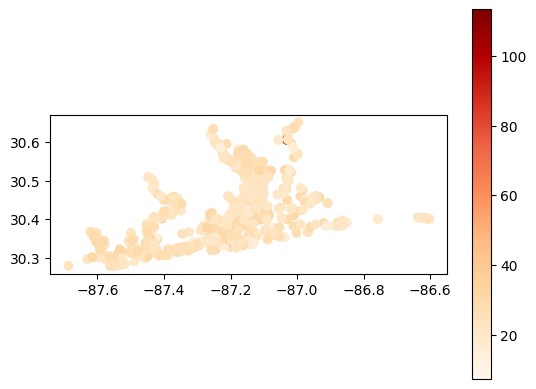

In [95]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)